# M7_AI1: Support Vector Machine
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad 1 propuesta en el Modulo **Técnicas Avanzadas de Machine Learning**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos.
#### Diciembre 8, 2024

# Enunciado
#### Contexto
En esta práctica realizaremos clasificación de imágenes con Support Vector Machine. Para ello, utilizaremos dos datasets: MNIST y Fashion-MNIST. 

#### MNIST 
- Es un dataset de dígitos de MNIST (Modified-NIST, del Instituto Nacional de Estándares y Tecnología de EEUU).
- Consta de 60.000 imágenes de entrenamiento y 10.000 de prueba. El tamaño de la imagen es de 28 x 28 píxeles. Cada imagen está etiquetada de 0 a 9 en función del dígito representado. 
- Se utiliza como banco de pruebas para clasificar imágenes con algoritmos de Machine Learning. 

#### Fashion-MNIST 
- Es un dataset de imágenes de artículos de moda de la empresa Zalando. Fue concebido para sustituir a MNIST porque requiere modelos de clasificación más complejos. 
- Mantiene las características de MNIST en cuanto a número de imágenes (60.000 de entrenamiento y 10.000 de prueba), tamaño de las imágenes (28 x 28 píxeles) y número de clases (10). 
- Se diferencia en el contenido de las imágenes: 10 tipos de artículos de moda, en lugar de los 10 dígitos. 

El objetivo es comparar el resultado (accuracy) en función del dataset y el tipo de kernel SVM.
Teniendo en cuenta la información anterior, te pedimos realizar las tareas siguientes: 

#### Dataset 
- Cargar ambos datasets desde tensorflow.
- Preprocesado: convertir las imágenes en vectores unidimensionales. 

#### Modelos de SVM: 
- Cargar el modelo de clasificador SVM de sklearn. 
- Utilizar dos tipos de kernel: Lineal y Gausiano.
- Entrenar con 20.000 imágenes.
- Probar con el dataset de prueba completo (10.000 imágenes).  

#### Consideraciones: 
- Para acortar el tiempo de entrenamiento con el kernel gaussiano, se aconseja: 
           -  Dejar el valor de gamma por defecto (“scale”).
           -  Dejar el valor de probability por defecto (“False”).

- Se requiere mostrar y comparar el resultado con cada kernel (no es suficiente con que lo compute internamente, por ejemplo, una función de grid search y saque el mejor resultado al final).
- En caso de que el conjunto de datos se procese de forma muy lenta, se recomienda reducir su tamaño de forma aleatoria a 5k. Si el problema persiste, reducir a 1k

# Solución

## Clasificación de imágenes MNIST 

### Carga de datos

In [1]:
# importamos las librerias
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import datetime
from time import time
from sklearn.svm import SVC

Importamos los datos mediante la librería `Tensorflow`

In [2]:
# cargamos los datos desde tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Exploramos las dimensiones de lo conjuntos de test y entrenamiento

In [3]:
# visualizamos perfiles de los datos
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Vemos que contamos con **60000** observaciones en nuestra partición de `entrenamiento` y **10000** en la de `testeo`. 

A su vez notamos que cada muestra es, en sí misma, una matriz de 28x28 registros, donde cada celda representa un pixel de la imagen. Como menciona el enunciado cada celda lleva un valor entero entre 0 y 255, y representa el color de cada pixel en escalas de grises.

Visualicemos las imagenes con las que trabajaremos para darnos una mejor idea de nuestro dataset de entrada

<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>
<class 'numpy.uint8'>


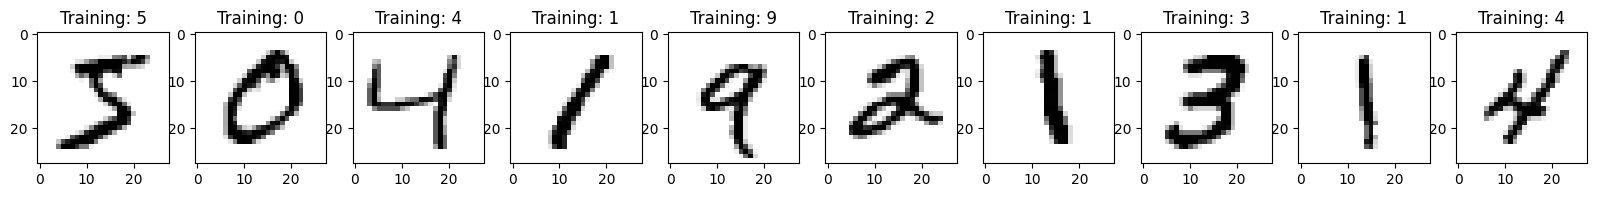

In [4]:
# declaramos un array con los nombres de las clases
class_names = ['0', '1', '2', '3', '4', '5',
               '6', '7', '8', '9']

# veamos algunas imagenes de entrenamiento
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))
# print(type(axes))
for ax, image, label in zip(axes, x_train, y_train):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    print(type(label))
    ax.set_title("Training: %s" % class_names[label])

Veamos la distribución de cada número (clase) en nuestra partición de entrenamiento

In [5]:
# vemos frecuencia de cada clase en `train`
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((class_names, counts)).T)

[['0' '5923']
 ['1' '6742']
 ['2' '5958']
 ['3' '6131']
 ['4' '5842']
 ['5' '5421']
 ['6' '5918']
 ['7' '6265']
 ['8' '5851']
 ['9' '5949']]


Hacemos lo mismo ahora para los datos de testeo

In [6]:
# vemos frecuencia de cada clase en `test`
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((class_names, counts)).T)

[['0' '980']
 ['1' '1135']
 ['2' '1032']
 ['3' '1010']
 ['4' '982']
 ['5' '892']
 ['6' '958']
 ['7' '1028']
 ['8' '974']
 ['9' '1009']]


Notamos que las clases, es decir los diferentes números representados por las imagenes que tenemos, están bien balanceadas tanto en el set de entrenamiento como en el de testeo. Esto nos indica que la métrica `accuracy` será representativa de la calidad de nuestro modelo.

### Preparación

Necesitamos adaptar los datos con los que contamos para que el algortimo de SVM pueda interpretarlos, esto implica hacer un `aplanamiento` de nuestras imagenes las cuales se encuentran reprentadas en una matriz de 2 dimensiones de 28x28. Utilizaremos la función `reshape` para ello

In [7]:
# aplanamos las matrices de las imagenes
x_train_r = x_train.reshape(len(x_train),-1)
x_test_r = x_test.reshape(len(x_test),-1)

# visualizamos la forma de las particiones
print(x_train_r.shape)
print(x_test_r.shape)

(60000, 784)
(10000, 784)


Luego de una fase inicial de experimentación con el dataset y el modelo SVM se determinó que se utilizará un set de entrenamiento de diez mil (10.000) imagenes, así como un set del mismo tamaño para la etapa de testeo

In [8]:
# seleccionamos las primeras 10000 imagenes
x_train_r = x_train_r[0:10000]
y_train = y_train[0:10000]

Veamos las formas de las particiones que tenemos

In [9]:
print(x_train_r.shape)
print(x_test_r.shape)

(10000, 784)
(10000, 784)


In [10]:
print(y_train.shape)
print(y_test.shape)

(10000,)
(10000,)


### Experimentación con kernel `Lineal` y diferentes valores de `C`

Kernel lineal con C = 1
SVC(C=1, kernel='linear')
Precisión (accuracy):  0.9123
Tiempo entrenamiento:  00:19:171914
Matriz de confusión:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.95      0.99      0.97      1135
           2       0.90      0.90      0.90      1032
           3       0.86      0.90      0.88      1010
           4       0.90      0.95      0.92       982
           5       0.90      0.84      0.87       892
           6       0.94      0.95      0.94       958
           7       0.92      0.91      0.91      1028
           8       0.89      0.85      0.87       974
           9       0.91      0.85      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

---------------------------------------

Kernel lineal con C = 10
SVC(C=10, kernel='linear')
Precisión (

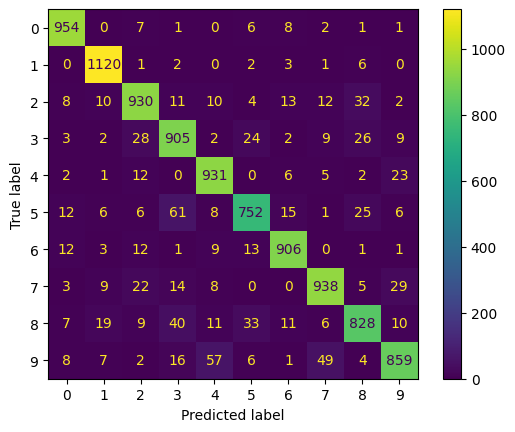

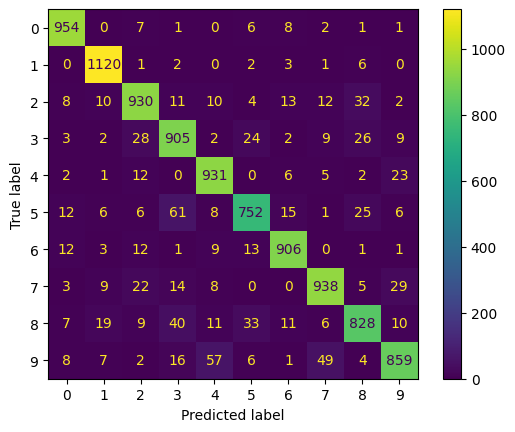

In [11]:
kernel = "linear"

for c in (1, 10):
  print("Kernel lineal con C =", c)

  timeIni = time()
  modelo = SVC(kernel = kernel, C=c).fit(x_train_r,y_train)
  print(modelo)
  timeEnd = time()
  timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

  acc = modelo.score(x_test_r, y_test)
  print("Precisión (accuracy): ", acc)
  print("Tiempo entrenamiento: ", timeDiff)

  predicciones = modelo.predict(x_test_r)
  print("Matriz de confusión:")

  cm = confusion_matrix(y_test, predicciones)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot()

  print(classification_report(y_test, predicciones))
  print("---------------------------------------")
  print()

Podemos notar como variar el valor del hiperparámetro `C` no incurre en una mejora en la precisión del modelo SVM con kernel `Lineal`, dando como resultado un desempeño general estable de **91.23%**. Se percibe una disminución en el tiempo de entrenamiento al subir el valor `C` de 1 a 10, la mejora ronda el 20% del tiempo de entrenamiento total.

### Experimentación con kernel `Gaussiano` y diversos valores de `gamma` y `C`

Kernel Gaussiano con gamma 'scale' con C= 1
SVC(C=1)
Precisión (accuracy):  0.9594
Tiempo entrenamiento:  00:26:465182
Matriz de confusión:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.97      0.94      0.96       892
           6       0.97      0.98      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.95      0.95       974
           9       0.96      0.92      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

---------------------------------------

Kernel Gaussiano con gamma 'scale' con C= 10
SVC(C=10)
Preci

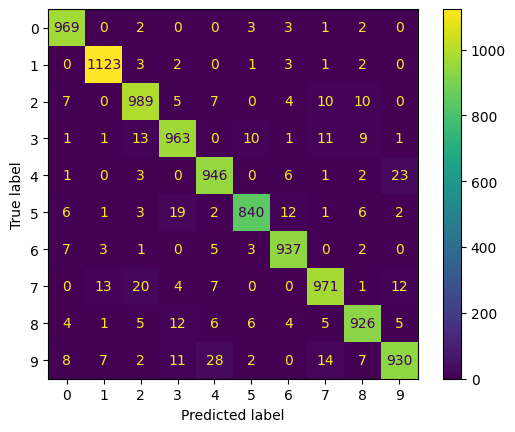

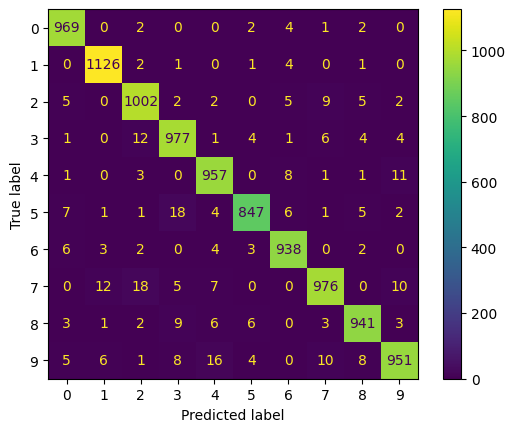

In [12]:
kernel = "rbf"

for c in ([1,10]):
    print("Kernel Gaussiano con gamma 'scale'", "con C=", c)
    timeIni = time()
    modelo = SVC(kernel = kernel, C=c).fit(x_train_r,y_train)
    print(modelo.fit(x_train_r, y_train))
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

    acc = modelo.score(x_test_r, y_test)
    print("Precisión (accuracy): ", acc)
    print("Tiempo entrenamiento: ", timeDiff)

    predicciones = modelo.predict(x_test_r)
    print("Matriz de confusión:")
    cm = confusion_matrix(y_test, predicciones)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    print(classification_report(y_test, predicciones))
    print("---------------------------------------")
    print()

Kernel Gaussiano

Para C = 1
- Precisión general (accuracy): 95.94%.
- Tiempo de entrenamiento: ~19.7 segundos.
- Promedio macro y ponderado: Ambos son muy altos (96%), indicando un buen balance en el desempeño para todas las clases.

Para C = 10:
- Precisión general (accuracy): 96.84%.
- Tiempo de entrenamiento: ~17.7 segundos.
- Promedio macro y ponderado: Mejora levemente (97%), confirmando que incrementar C mejora el ajuste del modelo.

### Conclusiones del enunciado
Se puede notar una mejora en la precisión general del modelo SVM con kernel `Gaussiano`, una mejora de entre 4 y 5 puntos porcentuales. Tambien podemos notar una clara complejidad computacional vinculada al uso del kernel `Gaussiano` expresada en función del tiempo de entrenamineto, siendo el kernel `Lineal` hasta 3 veces mas rápido que su contrapartida. Al utilizar el kernel `Gaussiano` notamos una mejora significativa en las clases mas problemáticas para el kernel `Lineal`, como se los numeros 3 y 5.

## Clasificación de imagenes Zalando

### Carga de datos

Importamos los datos mediante la librería `Tensorflow`

In [13]:
# importamos las imagenes
(x_train_fashion_raw, y_train_fashion), (x_test_fashion_raw, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

Vemos la forma de las particiones

In [14]:
# visualizamos shape de las particiones
print(x_train_fashion_raw.shape)
print(x_test_fashion_raw.shape)

(60000, 28, 28)
(10000, 28, 28)


Vemos que contamos con **60000** observaciones en nuestra partición de `entrenamiento` y **10000** en la de `testeo`. 

A su vez notamos que cada muestra es, en sí misma, una matriz de 28x28 registros, donde cada celda representa un pixel de la imagen. Como menciona el enunciado cada celda lleva un valor entero entre 0 y 255, y representa el color de cada pixel en escalas de grises.

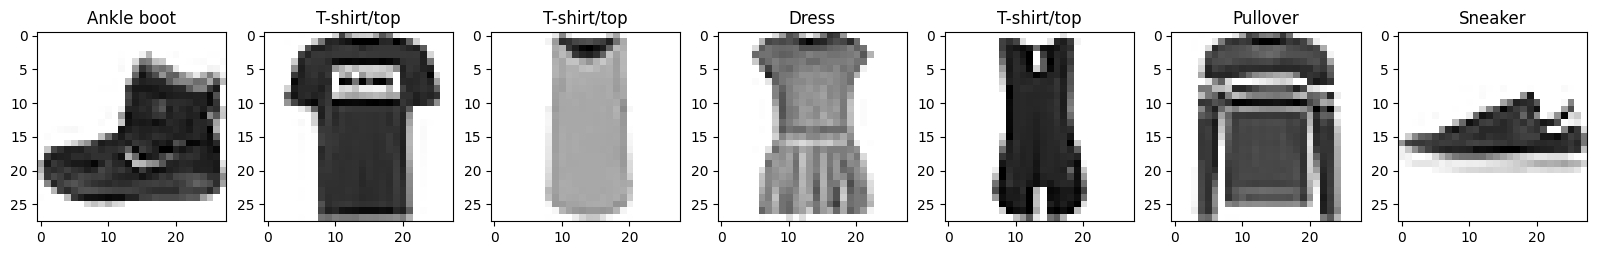

In [15]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

_, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 6))
for ax, image, label in zip(axes, x_train_fashion_raw, y_train_fashion):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%s" % class_names[label])

Vemos también que son 10 las posibles clases

In [16]:
# checkeamos frecuencia de cada clase en set de entrenamiento
unique, counts = np.unique(y_train_fashion, return_counts=True)
print(np.asarray((class_names, counts)).T)

[['T-shirt/top' '6000']
 ['Trouser' '6000']
 ['Pullover' '6000']
 ['Dress' '6000']
 ['Coat' '6000']
 ['Sandal' '6000']
 ['Shirt' '6000']
 ['Sneaker' '6000']
 ['Bag' '6000']
 ['Ankle boot' '6000']]


In [17]:
# checkeamos frecuencia de cada clase en set de testeo
unique, counts = np.unique(y_test_fashion, return_counts=True)
print(np.asarray((class_names, counts)).T)

[['T-shirt/top' '1000']
 ['Trouser' '1000']
 ['Pullover' '1000']
 ['Dress' '1000']
 ['Coat' '1000']
 ['Sandal' '1000']
 ['Shirt' '1000']
 ['Sneaker' '1000']
 ['Bag' '1000']
 ['Ankle boot' '1000']]


Las Clases están perfectamente balanceadas en el ambos sets, por lo que la métrica `accuracy` será un buen indicador de la precisión de nuestro modelo.

### Preparación

Al igual que en el apartado `Clasificación de imagenes MNIST`, ahora tambien necesitamos `aplanar` las matrices que representan las imagenes

In [18]:
# hacemos un reshape de las matrices
x_train_fashion = x_train_fashion_raw.reshape(len(x_train_fashion_raw),-1)
x_test_fashion = x_test_fashion_raw.reshape(len(x_test_fashion_raw),-1)

# vemos la nueva forma de las particiones
print(x_train_fashion.shape)
print(x_test_fashion.shape)

(60000, 784)
(10000, 784)


Por experimentación previa decidimos tomar solo las primeras 10.000 imágenes para entrenar los modelos SVM a continuacións

In [19]:
# seleccionamos las primeras 10000 imagenes
x_train_fashion = x_train_fashion[0:10000]
y_train_fashion = y_train_fashion[0:10000]

### Experimentación con kernel `Lineal` y diferentes valores de `C`

Kernel lineal con C = 1
SVC(C=1, kernel='linear')
Precisión (accuracy):  0.7964
Tiempo entrenamiento:  00:16:595659
Matriz de confusión:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1000
           1       0.95      0.96      0.96      1000
           2       0.58      0.71      0.64      1000
           3       0.81      0.78      0.79      1000
           4       0.71      0.64      0.67      1000
           5       0.92      0.90      0.91      1000
           6       0.54      0.46      0.49      1000
           7       0.88      0.92      0.90      1000
           8       0.95      0.92      0.93      1000
           9       0.93      0.92      0.93      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

---------------------------------------

Kernel lineal con C = 10
SVC(C=10, kernel='linear')
Precisión (

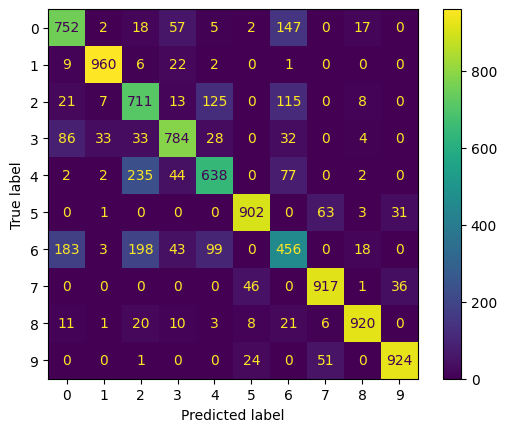

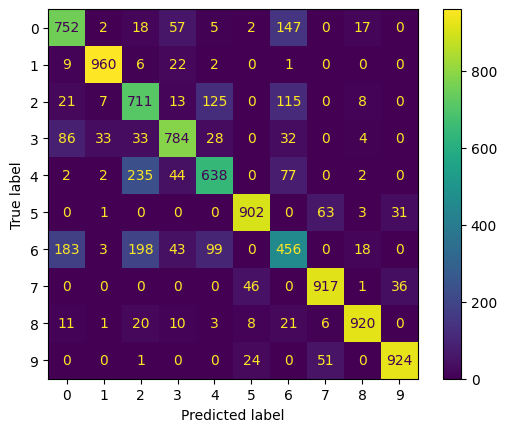

In [20]:
kernel = "linear"

for c in (1, 10):
  print("Kernel lineal con C =", c)

  timeIni = time()
  modelo = SVC(kernel = kernel, C=c).fit(x_train_fashion,y_train_fashion)
  print(modelo)
  timeEnd = time()
  timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

  acc = modelo.score(x_test_fashion, y_test_fashion)
  print("Precisión (accuracy): ", acc)
  print("Tiempo entrenamiento: ", timeDiff)

  predicciones = modelo.predict(x_test_fashion)
  print("Matriz de confusión:")

  cm = confusion_matrix(y_test_fashion, predicciones)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot()

  print(classification_report(y_test_fashion, predicciones))
  print("---------------------------------------")
  print()

Podemos apreciar que las modificaciones del valor `C` para el kernel `Lineal` al menos en este caso no reporta modificaciones en la precisión del modelo. 

Obteniendo una `accuracy` general de **79.64%** para ambos valores del hiperparámetro. Si notamos una leve disminución en el tiempo de entrenamiento, pasando de unos 15 a 13 segundos, al variar el valor de `C` de **1 a 10**.

Las clases 1, 8, y 9 tienen alta precisión (> 90%) y recall. Minetras que las clases 2, 4, y 6 tienen una precisión y recall bajos, especialmente la clase 6 (recall de 46%).

### Experimentación con kernel `Gaussiano` y diversos valores de `gamma` y `C`

Kernel Gaussiano con gamma 'scale' con C= 1
SVC(C=1)
Precisión (accuracy):  0.8531
Tiempo entrenamiento:  00:20:273821
Matriz de confusión:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1000
           1       0.99      0.95      0.97      1000
           2       0.75      0.79      0.77      1000
           3       0.82      0.88      0.85      1000
           4       0.76      0.77      0.77      1000
           5       0.94      0.93      0.94      1000
           6       0.64      0.59      0.62      1000
           7       0.91      0.92      0.91      1000
           8       0.96      0.96      0.96      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

---------------------------------------

Kernel Gaussiano con gamma 'scale' con C= 100
SVC(C=100)
Pre

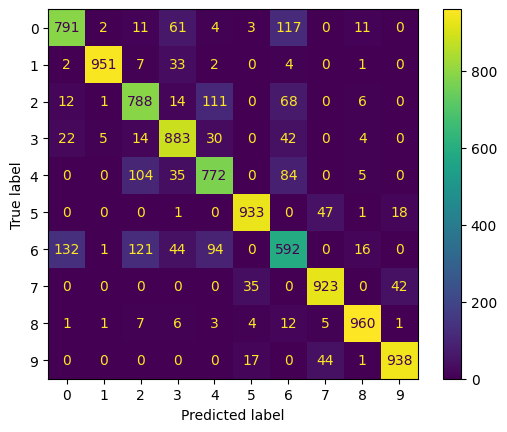

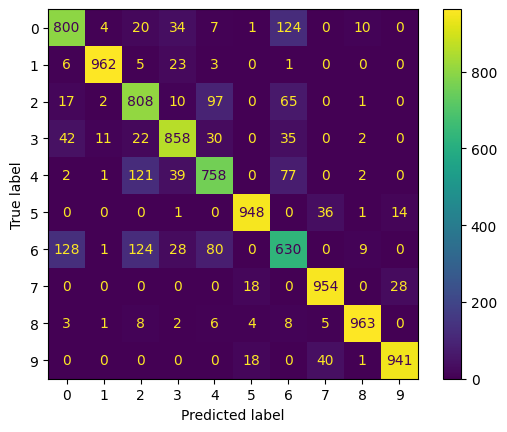

In [ ]:
kernel = "rbf"

for c in ([1,100]):
    print("Kernel Gaussiano con gamma 'scale'", "con C=", c)
    timeIni = time()
    modelo = SVC(kernel = kernel, C=c).fit(x_train_fashion,y_train_fashion)
    print(modelo.fit(x_train_fashion, y_train_fashion))
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

    acc = modelo.score(x_test_fashion, y_test_fashion)
    print("Precisión (accuracy): ", acc)
    print("Tiempo entrenamiento: ", timeDiff)

    predicciones = modelo.predict(x_test_fashion)
    print("Matriz de confusión:")
    cm = confusion_matrix(y_test_fashion, predicciones)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    print(classification_report(y_test_fashion, predicciones))
    print("---------------------------------------")
    print()

Kernel Gaussiano (RBF)

Para C = 1:

- Precisión general (accuracy): 85.31%
- Tiempo de entrenamiento: ~20 segundos.
- Mejor desempeño que el kernel lineal, especialmente en las clases 2, 3, 4, y 6.

Para C = 100:

- Precisión general (accuracy): 86.22%
- Tiempo de entrenamiento: ~16 segundos.

### Conclusiones del enunciado
Kernel Gaussiano (RBF) supera consistentemente al Kernel Lineal en términos de precisión general y desempeño en clases problemáticas (como 6 y 3). Incrementar el parámetro C con el kernel Gaussiano mejora ligeramente la precisión, especialmente en clases más difíciles, aunque aumenta el riesgo de sobreajuste en datos más complejos. En términos de balance entre precisión y tiempo de entrenamiento, Kernel Gaussiano con C=1 parece ser la mejor configuración.

## Conclusiones generales

El trabajo práctico nos permitió trabajar con diferentes datasets de imágenes, uno dedicado a muestras de números manuscritos y el otro con muestras de items comercilizables. También nos permitió exeperimentar con diferentes kernels dentro del algoritmo SVM, a su vez se nos requirió realizar una busqueda iterativa del impacto de cada hiperparámetro vinculado a cada kernel.

Se pudo notar a lo largo del trabajo práctico la sensibilidad del algoritmo SVM ante la cantidad de datos de entrada, siendo necesario recortar la cantidad de datos utilizados para la etapa de entrenamiento.

Del desarrollo surge que en el caso del dataset MNIST, se percibe alta precisión y bajos tiempos de entrenamiento para el kernel `Lineal`, performando casi con idéntico nivel de precision general que su contrapartida `Gaussiano`, pero siendo hasta 3 veces mas veloz que éste último. 

Mientras que en el caso del dataset de `Zalando` el cual cataloga diferentes tipos de prendas en 10 clases diferentes, la pérformance de ambos kernels disminuye considerablemente, siendo el kernel `Lineal` el de peor pérformance. Por su parte el kernel `Gaussiano` si consigue una precisión aceptable del orden del 86% al utilizar un valor del hiperpámetro `C` de 100.